In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
from scipy import stats
import os

%matplotlib inline

In [2]:
files = os.listdir('../Unprocessed_Data/')
full_df = []

for f in files:
    data = pd.read_csv(os.path.join('../Unprocessed_Data/', f), index_col=0)
    data['Role'] = os.path.basename(f).split('.')[0].replace('_',' ').title()
    full_df.append(data)
full_df = pd.concat(full_df)
full_df.to_csv(os.path.join('../Processed_Data/', 'data.csv'))


In [3]:
df = pd.read_csv('../Processed_Data/data.csv', index_col=0)
df.reset_index(drop=True, inplace=True)

In [4]:
df.describe(include='O')

,Company,Location,Date,Job_Title,Subspecialty,Total_Comp,Role
count,29913,29918,29919,29896,29082,29911,30294
unique,756,1084,1120,1680,1250,782,8
top,Amazon,"Seattle, WA",10/31/18,L4,Distributed Systems (Back-End),"$200,000",Software Engineer
freq,4333,3304,207,2248,6149,667,22541


In [5]:
df.isna().sum()

Company               381
Location              376
Date                  375
Job_Title             398
Subspecialty         1212
Years_Experience    29953
Total_Comp            383
Role                    0
dtype: int64

In [6]:
df.isna().sum() / df.shape[0]

Company             0.012577
Location            0.012412
Date                0.012379
Job_Title           0.013138
Subspecialty        0.040008
Years_Experience    0.988744
Total_Comp          0.012643
Role                0.000000
dtype: float64

# Preliminary Data Preparation
<p> Drop NaN rows where Total_Comp is missing.</p>
<p> Total_Comp is currently an object. Strip the $ and , from the values, and cast as a float.</p>
<p> Years_Experience is 98% empty. Drop the Years_Experience column. </p>
<p> The purpose of this exploration isn't to account for time dependency of the hire. Drop Date column </p>

In [7]:
df.head()

,Company,Location,Date,Job_Title,Subspecialty,Years_Experience,Total_Comp,Role
0,McKinsey,"San Francisco, CA",10/17/20,Senior Associate,Analytic,7.0,"$198,000",Consultant
1,Facebook,"Menlo Park, CA",10/16/20,L4,Product,5.0,"$177,000",Consultant
2,Accenture,"San Francisco, CA",10/15/20,Consultant,Analytic,3.0,"$120,000",Consultant
3,Salesforce,"Atlanta, GA",10/15/20,8,Operations,7.0,"$178,000",Consultant
4,Oracle,"San Francisco, CA",10/14/20,IC-4,Consumer,10.0,"$82,000",Consultant


In [8]:
df = df.dropna(subset=['Total_Comp'], axis=0)
df['Total_Comp'] = df['Total_Comp'].apply(lambda x: str(x).replace('$','').replace(',','')).astype(float)
df.isna().sum()

Company                 5
Location                0
Date                    0
Job_Title              19
Subspecialty          833
Years_Experience    29570
Total_Comp              0
Role                    0
dtype: int64

In [9]:
df.drop(columns=['Date', 'Years_Experience'], inplace= True)

In [10]:
df.describe(include=['O','float'])

,Company,Location,Job_Title,Subspecialty,Total_Comp,Role
count,29906,29911,29892,29078,2.991100e+04,29911
unique,756,1084,1680,1250,NaN,8
top,Amazon,"Seattle, WA",L4,Distributed Systems (Back-End),NaN,Software Engineer
freq,4332,3301,2247,6148,NaN,22468
mean,NaN,NaN,NaN,NaN,2.325723e+05,NaN
std,NaN,NaN,NaN,NaN,1.510995e+05,NaN
min,NaN,NaN,NaN,NaN,1.000000e+04,NaN
25%,NaN,NaN,NaN,NaN,1.500000e+05,NaN
50%,NaN,NaN,NaN,NaN,2.000000e+05,NaN
75%,NaN,NaN,NaN,NaN,2.800000e+05,NaN


# Exploratory Data Analysis
<p> Distribution of Total_Comp </p>
<p> Values and distribution of Company, Location, Job_Title, and Subspecialty </p>

In [11]:
print(df.Company.value_counts()[:10])
print("\nUnique Values:", df.Company.nunique())

Amazon        4332
Microsoft     3190
Google        2512
Facebook      1685
Apple         1053
Salesforce     674
Uber           592
Oracle         585
Cisco          470
LinkedIn       449
Name: Company, dtype: int64

Unique Values: 756


In [12]:
print(df.Location.value_counts()[:10])
print("\nUnique Values:", df.Location.nunique())

Seattle, WA          3301
San Francisco, CA    2505
New York, NY         1353
Redmond, WA          1209
Seattle, W           1127
Mountain View, CA     878
Sunnyvale, CA         870
San Francisco, C      835
San Jose, CA          681
Seattle, WA           636
Name: Location, dtype: int64

Unique Values: 1084


In [13]:
print(df.Subspecialty.value_counts()[:10])
print("\nUnique Values:", df.Subspecialty.nunique())

Distributed Systems (Back-End)    6148
Full Stack                        6145
API Development (Back-End)        3280
ML / AI                           2750
Web Development (Front-End)       1608
DevOps                             879
iOS                                737
Networking                         638
Security                           630
Android                            588
Name: Subspecialty, dtype: int64

Unique Values: 1250


## Initial Observations
<p> Location has values that did not combine due to minor input differences. Solution: strip the extra spaces, and extract only the city name. </p>
<p> All of these features have a wide variety of unique values. This will complicate future categorical encoding due to dimensionality concerns. Solution: use a threshold filter to compile infrequent values into an "Other" value for each feature.</p>
<p> Plot the frequency of variable and the variable count vs % of rows to derive threshold values </p>

In [14]:
df['Location'] = df['Location'].apply(lambda x: str(x).strip().split(',')[0])

In [15]:
df['Location'].value_counts()[:10]

Seattle          5066
San Francisco    3857
New York         2061
Redmond          1760
Mountain View    1340
Sunnyvale        1329
San Jose         1037
Menlo Park        876
Cupertino         743
Palo Alto         672
Name: Location, dtype: int64

In [16]:
def freq_plot(df, variable):
    pd.DataFrame({"Count": df[variable].value_counts()}).reset_index().plot()
    plt.legend('')
    plt.title(variable)
    plt.xlabel('Number of Variables')
    plt.ylabel('Frequency Count')
    plt.xlim(-10, df[variable].nunique())
    plt.grid()
    plt.tight_layout()
    plt.show()

In [17]:
def cumulative_plot(df, variable):
    X = pd.DataFrame({"Count": df[variable].value_counts()}).reset_index()
    X['Percentage'] = X['Count'] / sum(X['Count'])
    X['Cumulative'] = X['Percentage'].cumsum()
    X['Cumulative'].plot()
    plt.xlim(-10, 0.3 * df[variable].nunique())
    plt.title(variable)
    plt.grid()
    plt.tight_layout()
    plt.show()

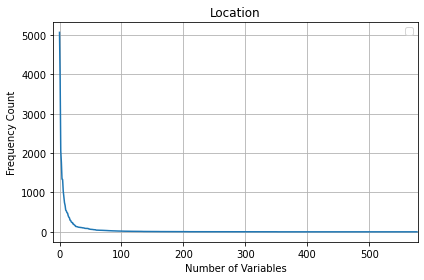

None


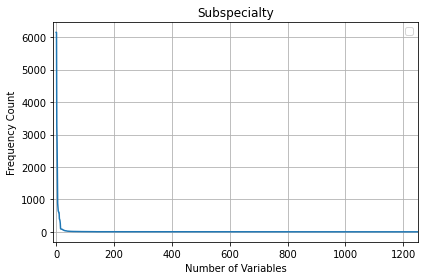

None


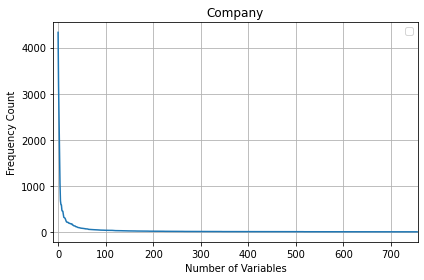

None


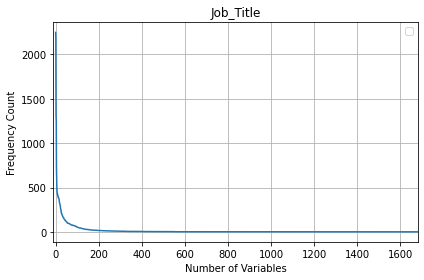

None


In [18]:
for var in ['Location', 'Subspecialty', 'Company', 'Job_Title']:
    print(freq_plot(df, var))

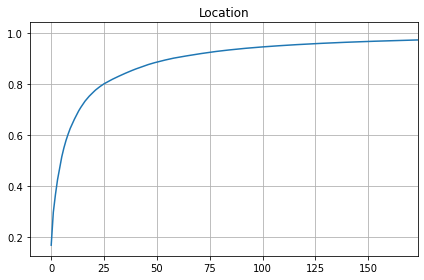

None


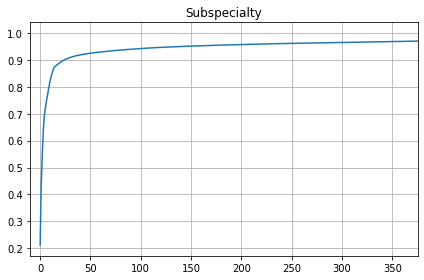

None


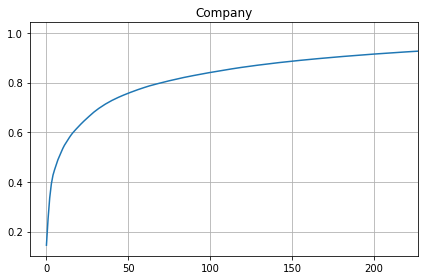

None


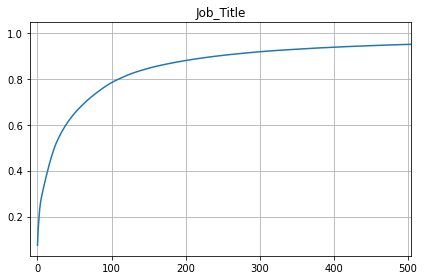

None


In [19]:
for var in ['Location', 'Subspecialty', 'Company', 'Job_Title']:
    print(cumulative_plot(df,var))

## Threshold Summary
<p> Location Threshold: 50 </p>
<p> Subspecialty Threshold: 25 </p>
<p> Company Threshold: 75 </p>
<p> Job Title: 100 </p>

In [20]:
def threshold(df, variable, thresh):
    var = df[variable].value_counts().index[:thresh]
    msk = df[variable].isin(var)
    df.loc[~msk, variable] = 'Other'

In [21]:
threshold(df, 'Company', 75)
threshold(df, 'Location', 50)
threshold(df, 'Job_Title', 100)
threshold(df, 'Subspecialty', 25)

## Visualizing Grouped Features

In [22]:
def grouped_plot(df, feature):
    plots = df.groupby(feature)['Total_Comp'].mean().sort_values(ascending=False)[:20]
    plt.bar(plots.index, plots)
    plt.xticks(rotation=90)
    plt.title(f'Total Compensation grouped by {feature}')
    plt.ylabel('Total Compensation ($)')
    plt.xlabel(f'{feature}')
    plt.show()

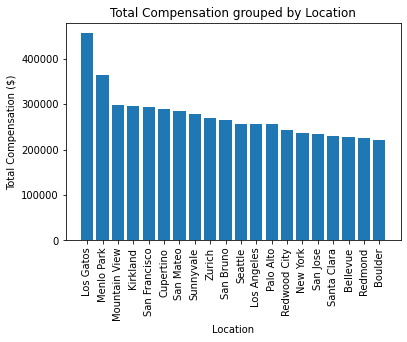

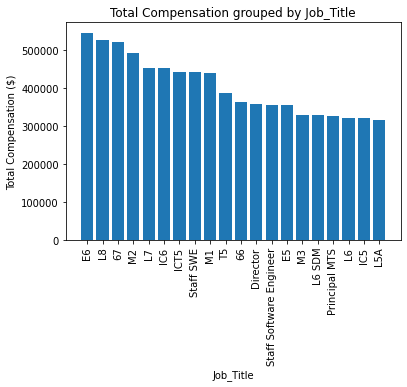

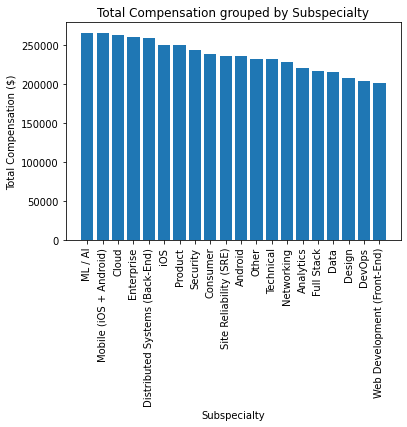

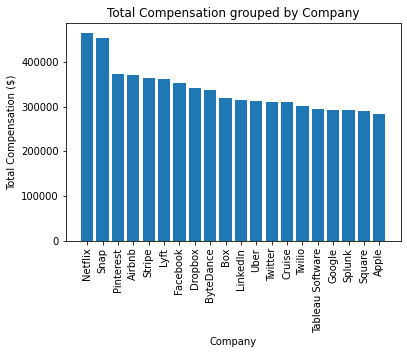

In [23]:
for var in ['Location', 'Job_Title', 'Subspecialty', 'Company']:
    grouped_plot(df, var)

## Outlier Exploration

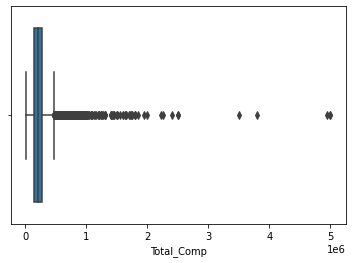

In [24]:
salaries = df['Total_Comp']
sns.boxplot(x=salaries)
plt.show()

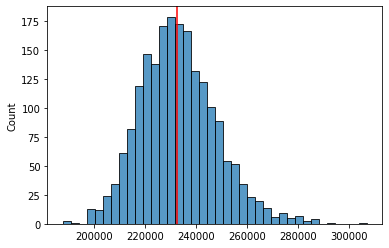

In [25]:
sample100 = [salaries.sample(100).mean() for _ in range(2000)]
plt.axvline(salaries.mean(), c='red')
sample100 = pd.Series(sample100)
sns.histplot(data=sample100)
plt.show()

<p> Validating the mean, and exploring a 90% Confidence Interval utilizing a bootstrap resampling. Even with the bootstrap, there is a persisting long tail.</p> 

In [26]:
list(round(sample100.quantile([0.05, 0.95])))

[210478.0, 259448.0]

## Outlier Removal
<p> To filter the extremely high Total_Comp values:</p>
<ul>
<li>Remove values > 1.5 * IQR</li>
</ul>

In [27]:
Q1 = df['Total_Comp'].quantile(0.25)
Q3 = df['Total_Comp'].quantile(0.75)
IQR = Q3 - Q1
outlier = Q3 + 1.5 * IQR

In [28]:
df[df['Total_Comp'] > outlier]

,Company,Location,Job_Title,Subspecialty,Total_Comp,Role
119,Deloitte,Other,Other,Other,600000.0,Consultant
353,Other,San Francisco,Other,Data,490000.0,Data Scientist
376,Amazon,Seattle,L7,Data,600000.0,Data Scientist
591,General Motors,Toronto,L8,Distributed Systems (Back-End),560000.0,Data Scientist
653,Google,Mountain View,L6,Full Stack,489000.0,Data Scientist
...,...,...,...,...,...,...
30036,Oracle,Seattle,Other,Distributed Systems (Back-End),550000.0,Technical Program Manager
30125,Uber,San Francisco,Other,Other,682000.0,Technical Program Manager
30156,Intel,Santa Clara,Other,Other,600000.0,Technical Program Manager
30241,Snap,Los Angeles,L6,Security,750000.0,Technical Program Manager


<p> 1581 records to be filtered using IQR. </p>

In [29]:
df = df[df['Total_Comp'] <= outlier].reset_index(drop=True)
df.shape

(28330, 6)

In [30]:
df['Total_Comp'].mean()

209087.5044122838

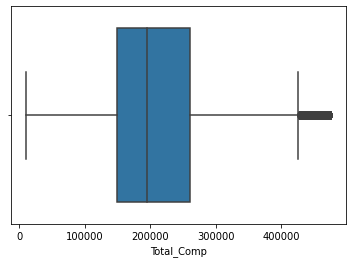

In [31]:
salaries = df['Total_Comp']
sns.boxplot(x=salaries)
plt.show()

<AxesSubplot:xlabel='Total_Comp', ylabel='Count'>

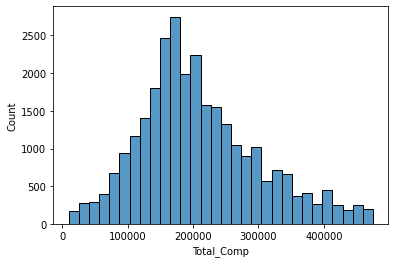

In [32]:
sns.histplot(df['Total_Comp'], bins=30)

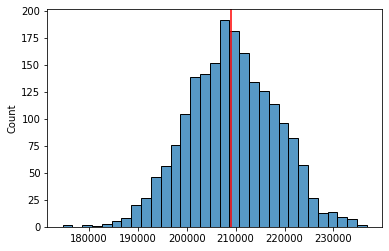

In [33]:
sample100 = [salaries.sample(100).mean() for _ in range(2000)]
plt.axvline(salaries.mean(), c='red')
sample100 = pd.Series(sample100)
sns.histplot(data=sample100)
plt.show()

In [34]:
list(round(sample100.quantile([0.05, 0.95])))

[194069.0, 223720.0]

<p> Create a binning of the Total_Comp for Classification Models</p>

In [35]:
df['Salary Bins'] = pd.qcut(df['Total_Comp'], q=10)

In [36]:
df.head()

,Company,Location,Job_Title,Subspecialty,Total_Comp,Role,Salary Bins
0,Other,San Francisco,Senior Associate,Other,198000.0,Consultant,"(195000.0, 215000.0]"
1,Facebook,Menlo Park,L4,Product,177000.0,Consultant,"(175000.0, 195000.0]"
2,Accenture,San Francisco,Consultant,Other,120000.0,Consultant,"(104000.0, 136000.0]"
3,Salesforce,Atlanta,8,Other,178000.0,Consultant,"(175000.0, 195000.0]"
4,Oracle,San Francisco,IC-4,Consumer,82000.0,Consultant,"(9999.999, 104000.0]"


## Final Step
<p> Export the dataframe as prepared.csv for model training and evaluation. Continued on a future notebook</p>

In [37]:
df.to_csv('../Processed_Data/prepared.csv')